# **Modelos de Classificação - Vision Transformers**


**O objetivo deste notebook é treinar modelos de aprendizado profundo para prever o rótulo/nome de uma determinada fruta tendo apenas uma imagem de entrada.**

## **Bibliotecas utilizadas**

In [ ]:
%%capture
!pip install opendatasets

In [ ]:
import os
import time
import copy
import pandas as pd
import tarfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import *
from torch import nn,optim
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel # Build up the pretrained transformers model
from sklearn.metrics import classification_report

## **Baixando dataset do Kaggle com OPENDATASETS**

In [ ]:
od.download('https://www.kaggle.com/moltean/fruits')
#marcosvmedeiros
#d356a300e335f97bbf3559a47bb0d29f

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marcosvmedeiros
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [01:01<00:00, 22.3MB/s]


In [ ]:
data_dir = '/content/fruits/fruits-360_dataset/fruits-360'
print(os.listdir(data_dir))

['papers', 'LICENSE', 'readme.md', 'Test', 'test-multiple_fruits', 'Training']


In [ ]:
len(os.listdir(data_dir + '/Training'))

131

## **Pré-processamento dos dados**

Setando device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Set up device and training hyperparameters
latent_dim = 256
epochs = 1
learning_rate = 5e-4

Construindo conjunto de dados e dataloader

In [ ]:
train_dir = data_dir + '/Training'
test_dir = data_dir + '/Test'
batch_size = 256

# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

In [ ]:
train_dataset = ImageFolder(train_dir, transform=data_transforms)
val_dataset = ImageFolder(test_dir, transform=data_transforms)

# carregando datasets no dataloader
train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset,batch_size=batch_size, shuffle=True)

Visualizando imagens

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


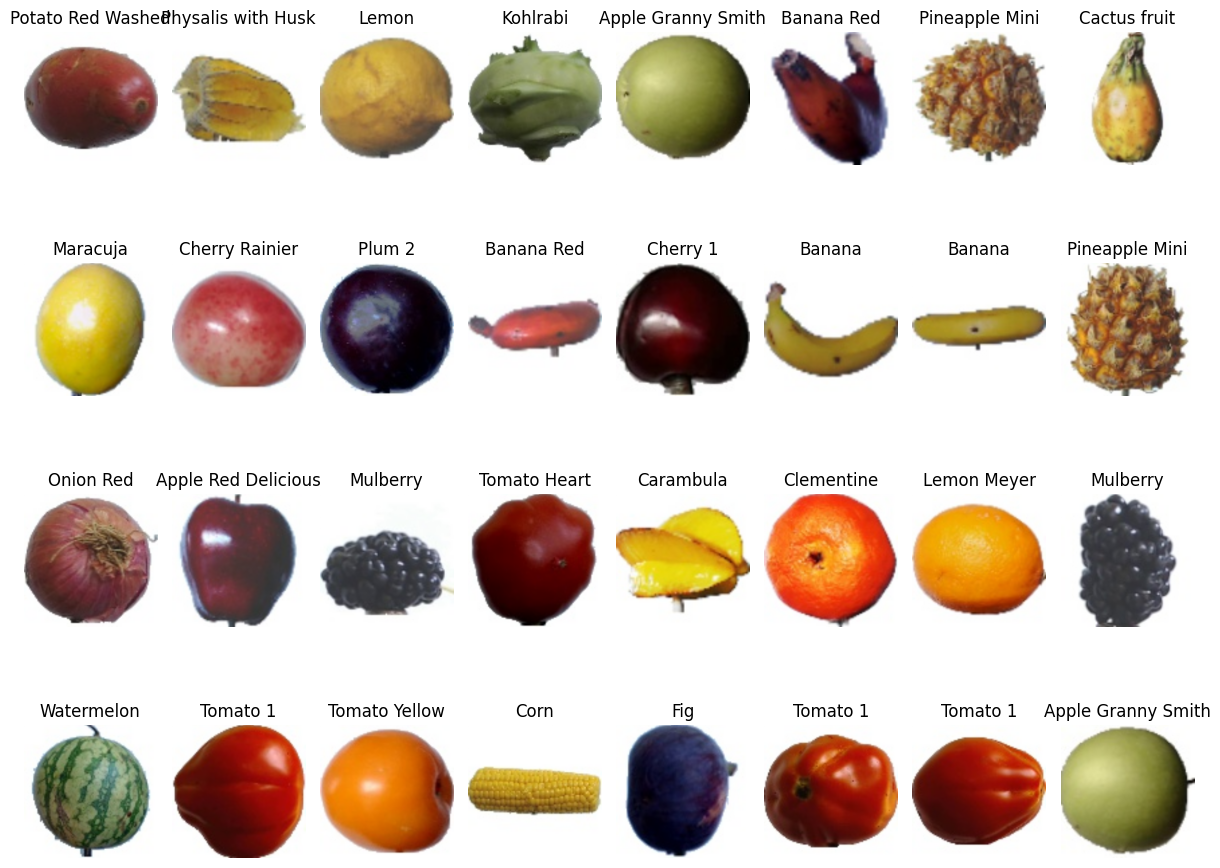

In [ ]:
image_size = 100
show_images, show_labels = next(iter(train_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

plt.figure(figsize=(12, 12))
def inverse_normalized(image):
    image = torch.clamp(input=image * 0.5 + 0.5, min=0.0, max=1.0)
    return image


for idx in range(len(show_images)):
    plt.subplot(nrows, ncols, idx + 1)
    plt.axis("off")
    plt.title(train_dataset.classes[show_labels[idx].item()])
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))
plt.tight_layout()

## **Arquitetura do modelo**

In [ ]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()
        self.classes_ = classes_
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)

    def forward(self, in_data):
        vit_outputs = self.vit(in_data)
        pooler_output = vit_outputs.pooler_output
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))

        return outputs

### Carregando modelo pré-treinados para Transfer Learning

In [ ]:
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Congelando parâmetros da rede para construir classificador

In [ ]:
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [ ]:
# Criando o modelo completo
model = CategoryClass(vit, latent_dim, len(train_dataset.classes)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

## **Treinamento do modelo**

In [ ]:
train_loss_history =[]
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    model.train()
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)
        # Print informações
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs} \t Average loss: {loss.item()} \t Average accuracy {accuracy}")

    # Set to the eval mode
    model.eval()
    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_images)
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]
    train_loss_history.append(train_epoch_loss / len(train_dataloader))
    train_accuracy_history.append(train_epoch_accuracy / len(train_dataloader))
    val_loss_history.append(val_epoch_loss / len(val_dataloader))
    val_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))

    # Print informações
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {traing_loss_history[-1]}, Average validation loss: {val_loss_history[-1]}")
    print(f"Average training accuracy: {train_accuracy_history[-1]}, Average validation accuracy: {val_accuracy_history[-1]}")

In [ ]:
# Save os pesos do modelp
torch.save(model.state_dict(), "model_transformer.pt")

## **Métricas do modelo**

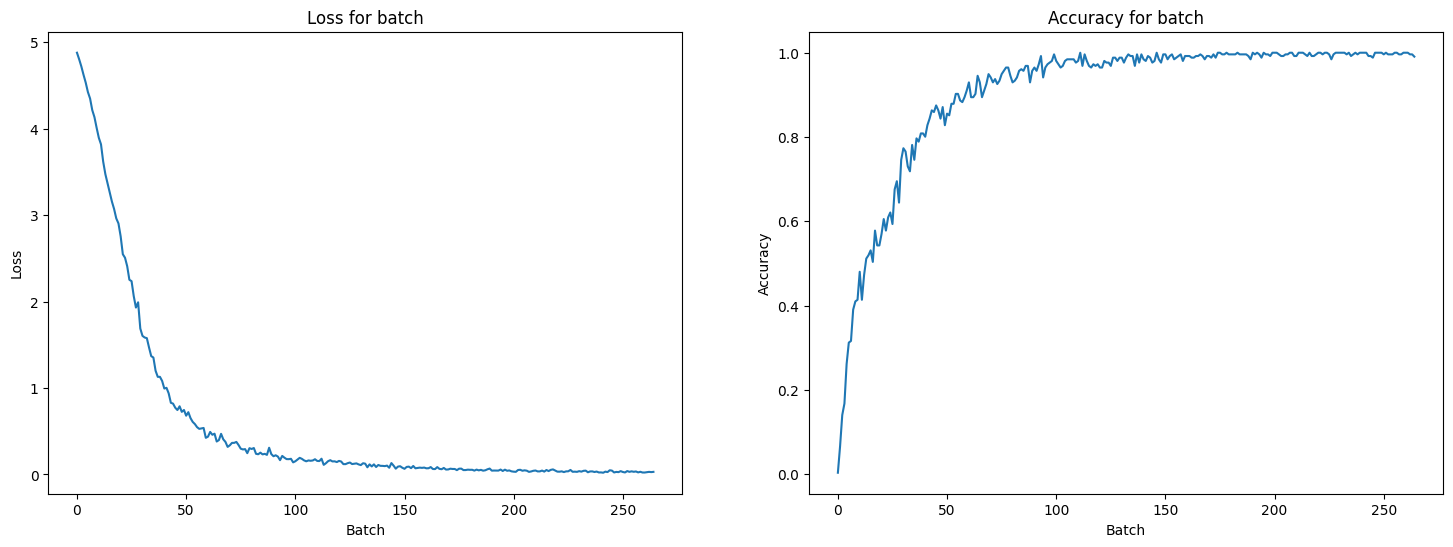

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)

## **Inferência**

### Inferência com image do conjunto de teste

In [ ]:
prediction = []
true_labels = []

with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_predict_class = val_outputs.argmax(dim=-1)
        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [ ]:
report = classification_report(true_labels, prediction,
                               output_dict=True,
                               target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
Apple Braeburn,0.911111,1.000000,0.953488,164.000000
Apple Crimson Snow,1.000000,0.993243,0.996610,148.000000
Apple Golden 1,1.000000,1.000000,1.000000,160.000000
Apple Golden 2,1.000000,1.000000,1.000000,164.000000
Apple Golden 3,0.985714,0.857143,0.916944,161.000000
Apple Granny Smith,0.891304,1.000000,0.942529,164.000000
Apple Pink Lady,0.993464,1.000000,0.996721,152.000000
Apple Red 1,1.000000,0.975610,0.987654,164.000000
Apple Red 2,0.981928,0.993902,0.987879,164.000000
Apple Red 3,1.000000,0.888889,0.941176,144.000000


from matplotlib import pyplot as plt
_df_0['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)